# RL -  Balancing an Inverted Pendulum

Name: Tan Wen Tao Bryan & Ryan Yeo <br>
Admin No: P2214449 & P2214452 <br>
Group: 1<br>
Class: DAAA/FT/2B/01<br>

# Project Objective
### **Objective**: 
- Address the inverted pendulum swing-up problem, a derivative of the classic control theory challenge.

### **Task**: 
- Initiate the pendulum from a randomized position and apply torque to the free end, aiming to swing it into an upright position and maintain balance.


# Table of contents
1. [Understanding the Environment](#understanding-the-environment)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
3. [DQN](#dqn)
   1. [Q Network](#q-network)
   2. [Experience Replay Buffer](#experience-replay-buffer)
   3. [Hyperparameter Tuning](#hyperparameter-tuning)
   4. [Action Space Discretization](#action-space-discretization)
4. [Double DQN](#double-dqn)
   1. [Hard Updates vs Soft Updates](#hard-updates-vs-soft-updates)
   2. [Prioritized Experience Relay](#prioritized-double-dqn)
5. [Summary](#summary)

<hr>

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

C:\Users\ryany\AppData\Local\Temp\ipykernel_5736\1230910842.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
!nvidia-smi

Thu Feb  1 10:23:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P8              12W /  50W |    178MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
import gymnasium as gym
import pygame
import warnings

# Ignore runtime warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

class InvertedPendulumEnv:
    def __init__(self, render=True):
        if render:
            self.env = gym.make("Pendulum-v1", g=9.81, render_mode="human")
        else:
            self.env = gym.make("Pendulum-v1", g=9.81)

    def initialize(self):
        pygame.init()
        pygame.display.set_mode((640, 480))  # Set the window size
        pygame.display.set_caption("Inverted Pendulum")  # Set the window title
        pygame.display.set_icon(pygame.image.load("Pendulum.bmp"))  # Set the icon

    def close(self):
        pygame.quit()
        print("Window closed by user.")
        return

<frozen importlib._bootstrap>:228: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


## **Understanding the Environment** 

#### <ins>**Description**</ins>

The goal of the inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum being attached at one end to a fixed point while the other end is free.

The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position and balance it there.

Each episode truncates at 200 time steps


<img src="https://gymnasium.farama.org/_images/pendulum.png" />

*Figure: Diagram of the coordinate system used for the implementation of the pendulum's dynamic equations*

#### <ins>**State (Observation)**</ins>

The state is a ndarray with shape (3, ) representing the x-y coordinates of the pendulum's free end and its angular velocity

||Observation|Min|Max|
|---|---|---|---|
Observation[0]| x = $cos(\theta)$ | -1.0 | 1.0 |
Observation[1]| y = $sin(\theta)$ | -1.0 | 1.0 |
Observation[2]| Angular Velocity | -8.0 | 8.0 |

#### <ins>**Action**</ins>

The action is a ndarray with shape (1, ) representing the torque applied to the free end of the pendulum. The action that can be taken by the inverted pendulum is **continuous**

||Action|Min|Max|
|---|---|---|---|
Action[0]| Torque, $\tau$ | -2.0 | 2.0 |

#### <ins>**Rewards**</ins>

The reward function is defined as

$$
\begin{equation}
r = -(\theta^2 + 0.1 {\.\theta}^2 + 0.001 \tau^2) \nonumber
\end{equation}
$$

where,

$\theta$: is the pendulum's angle normalized between [-$\pi$, $\pi$] (with 0 being in the upright position)

$\.\theta$: is the angular velocity

$\tau$: is the torque


Based on the above equation, the minimum reward that can be obtained is 

$$
\begin{align}
r &= -(\pi^2 + 0.1 \cdot 8^2 + 0.001 \cdot 2^2) \nonumber \\
&= -16.2736044 \nonumber
\end{align}
$$

while the maximum reward is zero when the pendulum is upright with zero velocity and no torque applied



## **Exploratory Data Analysis** 



EDA in Reinforcement Learning is a lot more unconventional since we don't have a fixed dataset but are instead interacting with an environment

Let us start by taking random actions in the environment over 500 episode (each episode truncates after 200 time steps). To speed up the run time, we will not render the environment

During this time, we will calculate the score for each episode (total sum of rewards accumulated during that episode) to check for any potential patterns

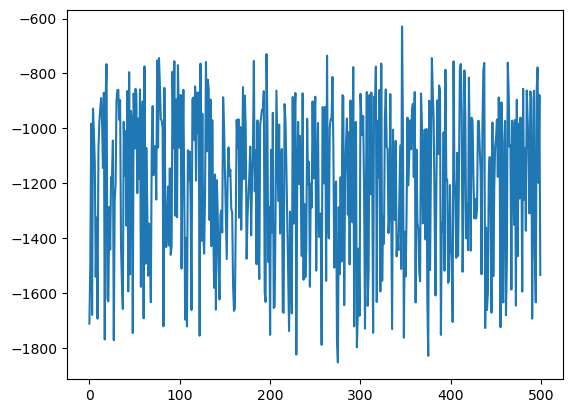

Result of first 100 episodes: -1171.6711336738656 ± 294.75715311011123
Average Score:-1201.8349788854468 ± 285.25674088252987
Max Score: -629.0143418820891
Min Score: -1851.6518192859712


In [5]:
# Render the environment
Env = InvertedPendulumEnv(render=False)
state, _info = Env.env.reset()

episodes = 500
score_list = []

for episode in range(episodes):
        state, _info = Env.env.reset()
        score, done = 0.0, False

        while not done:
            # Take a random action
            action =  action = Env.env.action_space.sample()

            new_state, reward, terminated, truncated, _ = Env.env.step(action)

            if terminated or truncated:
                done = True

            score += reward

            state = new_state

        score_list.append(score)

plt.plot(score_list)
plt.show()

print(f"Result of first 100 episodes: {np.mean(score_list[:100])} ± {np.std(score_list[:100])}")
print(f"Average Score:{np.mean(score_list)} ± {np.std(score_list)}")
print(f"Max Score: {np.max(score_list)}")
print(f"Min Score: {np.min(score_list)}")

**Observations**:
- When taking random actions over 500 episodes, we can see that the average score is around -1200 with a rather large flucutation as indicated by the standard deviation of around 280
- The score ranges from around -600 to -1800 which is quite big

Before building the model, we would have to look at the the best performance our model can possibly obtained. 

Theoretically, since the lowest possible reward is 0, the best possible score would be 0. However, this is highly unrealistic as it would require an extreme amount of luck for the pendulum to always be seeded to have an angle of 0 (i.e. an upright pendulum) 

OpenAI has a [leaderboard](https://github.com/openai/gym/wiki/Leaderboard#pendulum-v0) of the top best scores over 100 episodes with the results being around -100 to -150. Our goal is to reach close to state of the art results but most of the results are obtained using Policy Gradient Algorithms and Actor-Critic Networks so our results might be slightly worse

In [12]:
def evaluate_model_perf(agent, Env=InvertedPendulumEnv(render=False), episodes=100, simulations=5, printResults=True):
    """
    Evaluate Model's Performance
    """
    Env.env.reset()
    total_score = []

    for simulation in range(simulations):
        simulation_list = []
        for episode in range(episodes):
            state, _info = Env.env.reset()
            score, done = 0.0, False

            while not done:
                # Set epsilon to 0 duiring evaluation
                agent.epsilon = 0
                action, real_action = agent.choose_action(torch.FloatTensor(state))

                new_state, reward, terminated, truncated, _ = Env.env.step([real_action])
                
                if terminated or truncated:
                    done = True

                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        Env.close()

                score += reward
                state = new_state

            simulation_list.append(np.mean(score))
        total_score.append(simulation_list)

    if printResults:
        print(f"Result of 100 episodes: {np.mean(simulation_list)} ± {np.std(simulation_list)}")
    return f"{np.mean(simulation_list):.2f} ± {np.std(simulation_list):.2f}"


## **DQN** 

The basic idea behind many reinforcement learning algorithms is to estimate the action-value function, by using the Bellman equation ([Mnih et. al, Playing Atari with Deep Reinforcement Learning, 2015](https://arxiv.org/pdf/1312.5602.pdf))

$$
\begin{equation}
V(s) =
\begin{cases} 
    \alpha \cdot (R(s) + \gamma \cdot \underset{a}\max \, V(s_{t+1})), \text{ not terminated state} \\
    \alpha \cdot R(s), \text{ terminated state}
\end{cases}
\end{equation}
$$

where:
- $V(s)$ is the expected value at the current state $s$
- $R(s)$ is the given reward for taking action $a$ at state $s$
- $\gamma$ is the discount factor
- $\underset{a}\max \, V(s_{t+1})$ is the maximum expected value at the next state $s_{t+1}$

### **Q Network** 

One way to achieve this is to use a non-linear function approximater such as a neural network to approximate the action-value function. The vanilla Q Network is a fairly standard neural network architecture and could be as simple as a linear network with a few hidden layers.

We will be using the following Q Network Structure:

1. Input Layer
- Neurons: state_dim (3)
  
1. Fully Connected Layer
- Neurons: 64
- Activation Function: 'relu'

1. Fully Connected Layer
- Neurons: 32
- Activation Function: 'relu'

1. Output Layer
- Neurons: action_dim (9)
- Activation Function: 'Linear'

In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, learning_rate):
        super(QNetwork, self).__init__()
        self.fc_1 = nn.Linear(state_dim, 64)
        self.fc_2 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, action_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        return self.fc_out(x)

In order to train this network to be able to give good approximations of the action-value function, we would need to provide it with some sample data which will be collected in the form of a Replay Buffer.

### **Experience Replay Buffer** 

An Experience Replay Buffer gathers training samples by interacting with the environment.

For every timestep, the replay buffer should store:
1. State of the environment
2. Discrete Bin indicating the action Taken
3. Reward
4. New State of the environment (after taking the action)
5. Whether the current state is a terminated state

*Note*: It is important to note the difference between a *terminated* state and a *truncated* state as when calculating the value for each time step using Bellman's equation, we would have to exclude the calculation of the long term-rewards if the state is a *terminated* but not if its a *truncated* state.
(https://farama.org/Gymnasium-Terminated-Truncated-Step-API)

In [6]:
from collections import deque
class ReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = deque(maxlen=buffer_limit)
        self.max_size = buffer_limit

    # Insert a tuple into the Replay Buffer containing: State, Action Taken, Reward, New State, Boolean of whether it is a terminated state
    def put(self, transition):
        self.buffer.append(transition)

    # Randomly Sample form the Replay Buffer
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_lst.append([int(done)])

        s_batch = torch.tensor(s_lst, dtype=torch.float)
        a_batch = torch.tensor(a_lst, dtype=torch.int64)
        r_batch = torch.tensor(r_lst, dtype=torch.float)
        s_prime_batch = torch.tensor(s_prime_lst, dtype=torch.float)
        done_batch = torch.tensor(done_lst, dtype=torch.int)

        return s_batch, a_batch, r_batch, s_prime_batch, done_batch

    def size(self):
        return len(self.buffer)

### **DQN Agent** 

With the Q Network and the Replay Buffer, we would be able to estimate the action-value function and predict the best action for a given state.

However, the action taken by the DQN agent is not neccessarily the best action in the given state but it's an action executed according to an $\epsilon$-greedy policy. The overview of the entire process is given as follows:

1. Initialize replay memory to capacity $N$
2. Initialize the Q-network with random weights
3. During each time step, with probability $\epsilon$, select a random action $a_t$ otherwise, select the best action for the given state using the Q-network
4. Execute the action in the environment
5. Store the state, action, reward and new state in the replay buffer
6. Sample random batch of training data sampled from the replay memory
7. Perform gradient descent and update the Q-network


In [9]:
class DQNAgent:
    def __init__(self, use_gpu=False):
        self.state_dim     = 3
        self.action_dim    = 9 
        self.lr            = 0.01
        self.gamma         = 0.99
        self.epsilon       = 1
        self.epsilon_decay = 0.99
        self.epsilon_min   = 0.01
        self.buffer_size   = 1_000_000
        self.batch_size    = 256
        self.memory        = ReplayBuffer(self.buffer_size)
        self.action_list = np.linspace(-2, 2, self.action_dim)

        self.Q = QNetwork(self.state_dim, self.action_dim, self.lr)

        self.use_gpu = use_gpu  

        if self.use_gpu:
            self.Q.to(device)

    def choose_action(self, state):
        """
        Choose an action using an epsilon-greedy policy
        """
        random_number = np.random.rand()

        # Exploitation
        if self.epsilon < random_number:
            with torch.no_grad():
                if self.use_gpu:
                    state = state.to(device)

                action = int(torch.argmax(self.Q(state)))
        # Exploration
        else:
            action = int(np.random.choice([n for n in range(self.action_dim)]))
        
        # Get actual action
        real_action = self.action_list[action]

        return action, real_action

    def calc_value(self, mini_batch):
        """
        Calculate the value of the current state using the Bellman equation
        """
        state, action, reward, new_state, done = mini_batch
        with torch.no_grad():
            if self.use_gpu:
                state = state.to(device)
                new_state = new_state.to(device)
                action = action.to(device)
                reward = reward.to(device)
                done = done.to(device)

            # Calculate expected longterm return of the current state under policy π
            q_target = self.Q(new_state).max(1)[0].unsqueeze(1)
            
            # Compute the target using the Bellman equation
            # Note: No need to compute the Q value of the next state if it is terminal
            value = reward + self.gamma * q_target * (1 - done)
        return value

    def train_agent(self):
        # Sample from replay buffer
        mini_batch = self.memory.sample(self.batch_size)

        # Unpack
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = mini_batch

        if self.use_gpu:
            state_batch = state_batch.to(device)
            action_batch = action_batch.to(device)
            reward_batch = reward_batch.to(device)
            new_state_batch = new_state_batch.to(device)
            done_batch = done_batch.to(device)


        td_target = self.calc_value(mini_batch)

        # Train the Q network
        Q_a = self.Q(state_batch).gather(1, action_batch)
        q_loss = F.smooth_l1_loss(Q_a, td_target)
        self.Q.optimizer.zero_grad()
        q_loss.mean().backward()
        self.Q.optimizer.step()

        return float(q_loss)

In [10]:
DQNV1_agent = DQNAgent(use_gpu=True)

Env = InvertedPendulumEnv(render=False)

episodes = 250
score_list = []
loss_list = []

# Fill up the replay buffer with random actions
while DQNV1_agent.memory.size() < 4 * DQNV1_agent.batch_size:
    state, _info = Env.env.reset()
    done = False

    while not done:
        action, real_action = DQNV1_agent.choose_action(torch.FloatTensor(state))
        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        if terminated or truncated:
            done = True

        DQNV1_agent.memory.put((state, action, reward, new_state, terminated))
        state = new_state

# Train the agent
for episode in range(episodes):
    state, _info = Env.env.reset()
    score, eps_loss, done = 0.0, 0.0, False
    Q_action_count = 0

    while not done:
        action, real_action = DQNV1_agent.choose_action(torch.FloatTensor(state))

        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        DQNV1_agent.memory.put((state, action, reward, new_state, terminated))

        loss = DQNV1_agent.train_agent()
        

        if terminated or truncated:
            done = True

        score += reward
        eps_loss += loss

        state = new_state
    
    # Decay epsilon every episode
    DQNV1_agent.epsilon = max(DQNV1_agent.epsilon_min, DQNV1_agent.epsilon*DQNV1_agent.epsilon_decay)

    print(f"EP:{episode+1}, Average Score:{score:.1f}, Average Loss:{eps_loss:.2f}, Epsilon:{DQNV1_agent.epsilon:.5f}")

    score_list.append(score)
    loss_list.append(eps_loss)

C:\Users\ryany\AppData\Local\Temp\ipykernel_13000\1713052966.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  s_batch = torch.tensor(s_lst, dtype=torch.float)


EP:1, Average Score:-1339.4, Average Loss:1714.04, Epsilon:0.99000
EP:2, Average Score:-954.8, Average Loss:1520.04, Epsilon:0.98010
EP:3, Average Score:-1064.5, Average Loss:1593.66, Epsilon:0.97030
EP:4, Average Score:-968.1, Average Loss:1438.94, Epsilon:0.96060
EP:5, Average Score:-964.7, Average Loss:1313.03, Epsilon:0.95099
EP:6, Average Score:-880.5, Average Loss:1256.80, Epsilon:0.94148
EP:7, Average Score:-1409.9, Average Loss:1407.54, Epsilon:0.93207
EP:8, Average Score:-819.4, Average Loss:1378.43, Epsilon:0.92274
EP:9, Average Score:-1642.6, Average Loss:1304.74, Epsilon:0.91352
EP:10, Average Score:-1069.4, Average Loss:1543.15, Epsilon:0.90438
EP:11, Average Score:-1743.7, Average Loss:1644.09, Epsilon:0.89534
EP:12, Average Score:-1013.7, Average Loss:1770.57, Epsilon:0.88638
EP:13, Average Score:-764.3, Average Loss:1430.41, Epsilon:0.87752
EP:14, Average Score:-1228.2, Average Loss:1683.42, Epsilon:0.86875
EP:15, Average Score:-989.6, Average Loss:1564.06, Epsilon:0.86

In [11]:
# Create a dataframe to store the results
scores_df = pd.DataFrame(columns=["Model", "Description", "Scores", "Solved In"])

Result of 100 episodes: -1399.2889424982893 ± 246.07144174247648


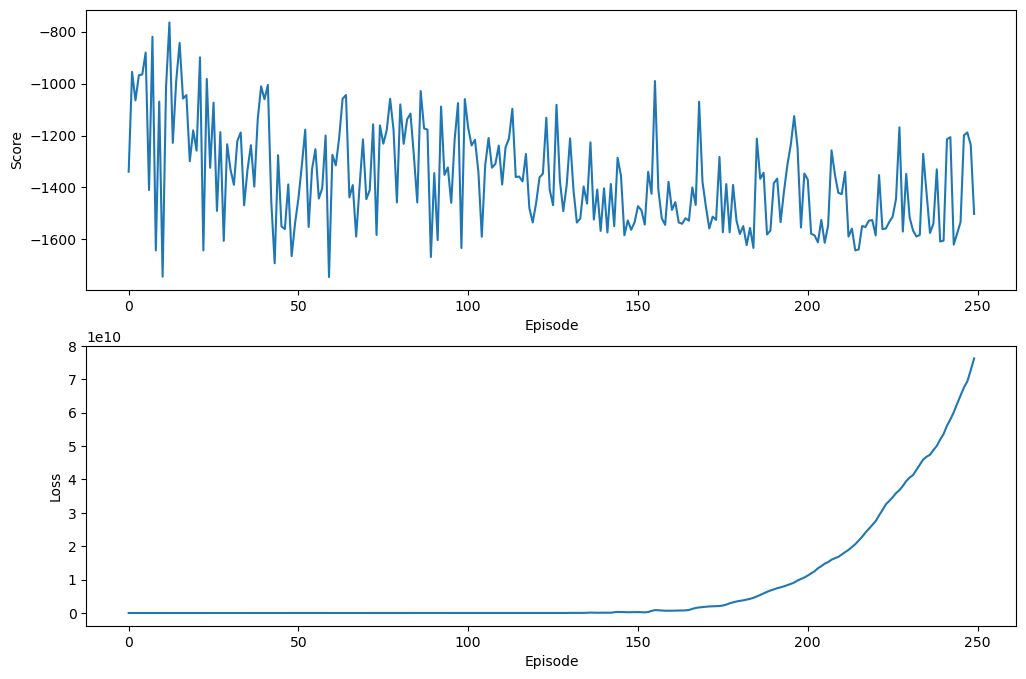

In [12]:
DQNV1_score = evaluate_model_perf(DQNV1_agent, simulations=10)

# Plot a subplot of the score and loss
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(score_list)
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Episode")

ax[1].plot(loss_list)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Episode")

plt.show()

In [13]:
scores_df.loc[len(scores_df)] = ["DQN", "DQN", DQNV1_score, "Never"]

**Observations**:
- Over a 100 episodes, we see that our average score is pretty much the same as taking random actions
- In fact, when observing the loss of our model, it seems that the loss is increasing as the number of episodes increase which confirms that the model is not learning at all

### **Hyperparameter Tuning** 

- <ins>Learning Rate</ins>
  
Previously, the learning rate was too high at 0.01 so we would have to decrease it to a lower value of 0.001

- <ins>Discount Factor</ins> ($\gamma$)
  
The discount factor is one of the most importnat factors when tuning DQN. A discount factor that is too low would only care about the present with no regard for future rewards while a discount factor that is too high would be overly optimistic such that is overestimates the amount of future rewards that it receives. For a given state, the return can be simplified to: $ Return_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ...$. This means that the effective time horizon is given as: $1 + \gamma + \gamma^2 + ... = \frac{1}{1-\gamma}$ ([John Schulman, The Nuts and Bolts of Deep RL Research, 2016](https://rll.berkeley.edu/deeprlcourse/docs/nuts-and-bolts.pdf)). This means that for our previous discount factor of 0.99, it ignore rewards delayed by $\frac{1}{1-\gamma}=100$ timesteps. This means that the instability in the training of the DQN is likely because the Q Network was overly optimistic when estimating its future reward. As such, we should reduce the discount factor to ignore rewards delayed by a smaller number of timesteps such as 25 time steps. This would then give us a discount factor of $\gamma=1-\frac{1}{20}=0.95$ which should hopefully make the Q Network give more realistic future rewards

In [14]:
class DQNAgentV2:
    def __init__(self, use_gpu=False):
        self.state_dim     = 3
        self.action_dim    = 9 
        self.lr            = 0.001
        self.gamma         = 0.95
        self.epsilon       = 1
        self.epsilon_decay = 0.99
        self.epsilon_min   = 0.01
        self.buffer_size   = 1_000_000
        self.batch_size    = 256
        self.memory        = ReplayBuffer(self.buffer_size)
        self.action_list = np.linspace(-2, 2, self.action_dim)

        self.Q = QNetwork(self.state_dim, self.action_dim, self.lr)

        self.use_gpu = use_gpu  

        if self.use_gpu:
            self.Q.to(device)

    def choose_action(self, state):
        """
        Choose an action using an epsilon-greedy policy
        """
        random_number = np.random.rand()

        # Exploitation
        if self.epsilon < random_number:
            with torch.no_grad():
                if self.use_gpu:
                    state = state.to(device)

                action = int(torch.argmax(self.Q(state)))
                
        # Exploration
        else:
            action = int(np.random.choice([n for n in range(self.action_dim)]))
        
        # Get actual action
        real_action = self.action_list[action]

        return action, real_action

    def calc_value(self, mini_batch):
        """
        Calculate the value of the current state using the Bellman equation
        """
        state, action, reward, new_state, done = mini_batch
        with torch.no_grad():
            if self.use_gpu:
                state = state.to(device)
                new_state = new_state.to(device)
                action = action.to(device)
                reward = reward.to(device)
                done = done.to(device)

            # Calculate expected longterm return of the current state under policy π
            q_target = self.Q(new_state).max(1)[0].unsqueeze(1)
            
            # Compute the target using the Bellman equation
            # Note: No need to compute the Q value of the next state if it is terminal
            value = reward + self.gamma * q_target * (1 - done)
        return value

    def train_agent(self):
        # Sample from replay buffer
        mini_batch = self.memory.sample(self.batch_size)

        # Unpack
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = mini_batch

        if self.use_gpu:
            state_batch = state_batch.to(device)
            action_batch = action_batch.to(device)
            reward_batch = reward_batch.to(device)
            new_state_batch = new_state_batch.to(device)
            done_batch = done_batch.to(device)


        td_target = self.calc_value(mini_batch)

        # Train the Q network
        Q_a = self.Q(state_batch).gather(1, action_batch)
        q_loss = F.smooth_l1_loss(Q_a, td_target)
        self.Q.optimizer.zero_grad()
        q_loss.mean().backward()
        self.Q.optimizer.step()

        return float(q_loss)

In [47]:
DQNV2_agent = DQNAgentV2(use_gpu=True)

Env = InvertedPendulumEnv(render=False)

episodes = 250

score_list = []
loss_list = []

# Fill up the replay buffer with random actions
while DQNV2_agent.memory.size() < 4 * DQNV2_agent.batch_size:
    state, _info = Env.env.reset()
    done = False

    while not done:
        action, real_action = DQNV2_agent.choose_action(torch.FloatTensor(state))
        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        if terminated or truncated:
            done = True

        DQNV2_agent.memory.put((state, action, reward, new_state, terminated))
        state = new_state

# Train the agent
for episode in range(episodes):
    state, _info = Env.env.reset()
    score, eps_loss, done = 0.0, 0.0, False
    Q_action_count = 0

    while not done:
        action, real_action = DQNV2_agent.choose_action(torch.FloatTensor(state))

        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        DQNV2_agent.memory.put((state, action, reward, new_state, terminated))

        loss = DQNV2_agent.train_agent()
        

        if terminated or truncated:
            done = True

        score += reward
        eps_loss += loss

        state = new_state
    
    # Decay epsilon every episode
    DQNV2_agent.epsilon = max(DQNV2_agent.epsilon_min, DQNV2_agent.epsilon*DQNV2_agent.epsilon_decay)

    print(f"EP:{episode+1}, Average Score:{score:.1f}, Average Loss:{eps_loss:.2f}, Epsilon:{DQNV2_agent.epsilon:.5f}")

    score_list.append(score)
    loss_list.append(eps_loss)

EP:1, Average Score:-922.7, Average Loss:985.03, Epsilon:0.99000
EP:2, Average Score:-749.7, Average Loss:1242.07, Epsilon:0.98010
EP:3, Average Score:-1756.0, Average Loss:552.66, Epsilon:0.97030
EP:4, Average Score:-1409.8, Average Loss:382.68, Epsilon:0.96060
EP:5, Average Score:-1709.4, Average Loss:534.06, Epsilon:0.95099
EP:6, Average Score:-917.3, Average Loss:724.51, Epsilon:0.94148
EP:7, Average Score:-1217.7, Average Loss:608.66, Epsilon:0.93207
EP:8, Average Score:-1056.1, Average Loss:489.34, Epsilon:0.92274
EP:9, Average Score:-1003.1, Average Loss:353.93, Epsilon:0.91352
EP:10, Average Score:-1146.1, Average Loss:369.56, Epsilon:0.90438
EP:11, Average Score:-1715.3, Average Loss:541.71, Epsilon:0.89534
EP:12, Average Score:-1365.7, Average Loss:587.66, Epsilon:0.88638
EP:13, Average Score:-1043.2, Average Loss:535.63, Epsilon:0.87752
EP:14, Average Score:-1414.9, Average Loss:487.10, Epsilon:0.86875
EP:15, Average Score:-1432.9, Average Loss:480.89, Epsilon:0.86006
EP:16,

Result of 100 episodes: -153.2746744281979 ± 100.51275779188158


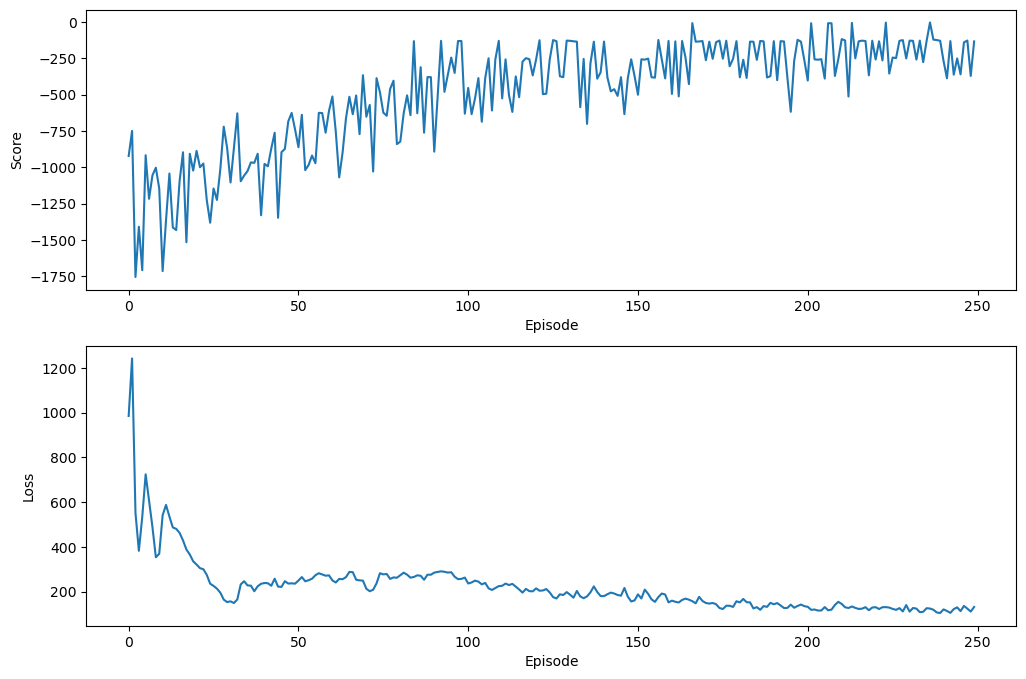

In [49]:
DQNV2_score = evaluate_model_perf(DQNV2_agent, simulations=10)

# Plot a subplot of the score and loss
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(score_list)
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Episode")

ax[1].plot(loss_list)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Episode")

plt.show()

In [53]:
scores_df.loc[len(scores_df)] = ["DQN", "Tuned Gamma", DQNV2_score, 90]

**Observations**:
- After adjusting the discount factor, we can see an improvement in the agent such as the agent being able to achieve a score of -153 and a decrease in loss as training goes by
- We see that from the scores that it plateaus around 90 episodes suggesting that it took around 110 episodes for the agent to finally be able to balance the pendulum

### **Action Space Discretization** 

Since the action space for this problem is continuous (torque applied can range from [-2, 2]) but DQN only works with discrete actions, the best way of dealing with this is to discretise the action space into bins. DQN does not typically generalise well to a larger discrete action space as finding the opimal action in a large space becomes harder and DQN's epsilon-greedy exploration strategy might not be efficient enough to adequately explore all actions and discover the optimal policies.

Previously, we arbitarily chose a value of 9 bins to discretise our action space into. However, when rendering the pendulum, we can see that the pendulum typically has to "overcome" two common states in order to be able to balance itself upright:
1. When the pendulum is vertically downwards, it requires a large amount of torque in order for it to swing into an upright position
2. When the pendulum is close to being vertically upwards, it requires a small amount of torque in order for it to be able to balance itself without using much torque, increasing the reward

To overcome this, we can try to discretize our actions in a way such that it there are towards the centre and at the sides and compare it against an evenly spaced discretized action space. In addition, we can also increase the number of actions taken from 9 to 51

<ins>Evenly spaced bins from -2 to 2</ins>

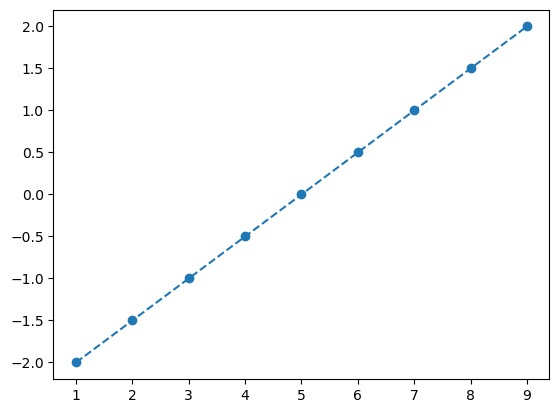

In [22]:
import numpy as np
import matplotlib.pyplot as plt

y = np.linspace(-2, 2, 9)
x = np.linspace(1,9, 9)

plt.plot(x, y, marker='o', linestyle='--')
plt.show()

<ins>Apply a quadtratic transformation</ins>

[-2.   -1.53 -1.12 -0.78 -0.5  -0.28 -0.12 -0.03  0.    0.03  0.12  0.28
  0.5   0.78  1.12  1.53  2.  ]


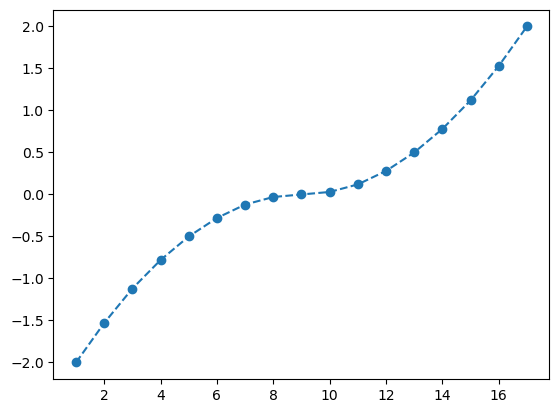

In [7]:
def transform_action_values(n_actions, target_min_action=-2.0, target_max_action=2.0):
    # Linearly spaced values between -0.5 and 0.5
    linear_actions = np.linspace(-0.5, 0.5, n_actions)

    # Apply a quadratic transformation
    non_linear_actions = np.sign(linear_actions) * (linear_actions ** 2)
    
    # Get the min and max values of the transformed actions
    measure_min = np.min(non_linear_actions)
    measure_max = np.max(non_linear_actions)

    # Scale to the action range of the environment
    scaled_actions = target_min_action + ((non_linear_actions - measure_min) * (target_max_action - target_min_action) / (measure_max - measure_min))
    # Round to 2 decimal places
    scaled_actions = np.round(scaled_actions, 2)
    return scaled_actions

y = transform_action_values(17)
x = np.linspace(1, 17, 17)
print(y)

plt.plot(x, y, marker='o', linestyle='--')
plt.show()


In [58]:
class DQNAgentV3:
    def __init__(self, use_gpu=False):
        self.state_dim     = 3
        self.action_dim    = 17 
        self.lr            = 0.001
        self.gamma         = 0.95
        self.epsilon       = 1
        self.epsilon_decay = 0.95
        self.epsilon_min   = 0.01
        self.buffer_size   = 1_000_000
        self.batch_size    = 256
        self.memory        = ReplayBuffer(self.buffer_size)
        self.action_list = transform_action_values(self.action_dim)

        self.Q = QNetwork(self.state_dim, self.action_dim, self.lr)

        self.use_gpu = use_gpu  

        if self.use_gpu:
            self.Q.to(device)

    def choose_action(self, state):
        """
        Choose an action using an epsilon-greedy policy
        """
        random_number = np.random.rand()

        # Exploitation
        if self.epsilon < random_number:
            with torch.no_grad():
                if self.use_gpu:
                    state = state.to(device)

                action = int(torch.argmax(self.Q(state)))
                
        # Exploration
        else:
            action = int(np.random.choice([n for n in range(self.action_dim)]))
        
        # Get actual action
        real_action = self.action_list[action]

        return action, real_action

    def calc_value(self, mini_batch):
        """
        Calculate the value of the current state using the Bellman equation
        """
        state, action, reward, new_state, done = mini_batch
        with torch.no_grad():
            if self.use_gpu:
                state = state.to(device)
                new_state = new_state.to(device)
                action = action.to(device)
                reward = reward.to(device)
                done = done.to(device)

            # Calculate expected longterm return of the current state under policy π
            q_target = self.Q(new_state).max(1)[0].unsqueeze(1)
            
            # Compute the target using the Bellman equation
            # Note: No need to compute the Q value of the next state if it is terminal
            value = reward + self.gamma * q_target * (1 - done)
        return value

    def train_agent(self):
        # Sample from replay buffer
        mini_batch = self.memory.sample(self.batch_size)

        # Unpack
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = mini_batch

        if self.use_gpu:
            state_batch = state_batch.to(device)
            action_batch = action_batch.to(device)
            reward_batch = reward_batch.to(device)
            new_state_batch = new_state_batch.to(device)
            done_batch = done_batch.to(device)


        td_target = self.calc_value(mini_batch)

        # Train the Q network
        Q_a = self.Q(state_batch).gather(1, action_batch)
        q_loss = F.smooth_l1_loss(Q_a, td_target)
        self.Q.optimizer.zero_grad()
        q_loss.mean().backward()
        self.Q.optimizer.step()

        return float(q_loss)

In [59]:
DQNV3_agent = DQNAgentV3(use_gpu=True)

Env = InvertedPendulumEnv(render=False)

episodes = 250

score_list = []
loss_list = []

# Fill up the replay buffer with random actions
while DQNV3_agent.memory.size() < 4 * DQNV3_agent.batch_size:
    state, _info = Env.env.reset()
    done = False

    while not done:
        action, real_action = DQNV3_agent.choose_action(torch.FloatTensor(state))
        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        if terminated or truncated:
            done = True

        DQNV3_agent.memory.put((state, action, reward, new_state, terminated))
        state = new_state

# Train the agent
for episode in range(episodes):
    state, _info = Env.env.reset()
    score, eps_loss, done = 0.0, 0.0, False
    Q_action_count = 0

    while not done:
        action, real_action = DQNV3_agent.choose_action(torch.FloatTensor(state))

        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        DQNV3_agent.memory.put((state, action, reward, new_state, terminated))

        loss = DQNV3_agent.train_agent()
        

        if terminated or truncated:
            done = True

        score += reward
        eps_loss += loss

        state = new_state
    
    # Decay epsilon every episode
    DQNV3_agent.epsilon = max(DQNV3_agent.epsilon_min, DQNV3_agent.epsilon*DQNV3_agent.epsilon_decay)

    print(f"EP:{episode+1}, Average Score:{score:.1f}, Average Loss:{eps_loss:.2f}, Epsilon:{DQNV3_agent.epsilon:.5f}")

    score_list.append(score)
    loss_list.append(eps_loss)

EP:1, Average Score:-862.2, Average Loss:705.03, Epsilon:0.95000
EP:2, Average Score:-1723.0, Average Loss:913.68, Epsilon:0.90250
EP:3, Average Score:-1352.8, Average Loss:453.27, Epsilon:0.85737
EP:4, Average Score:-869.8, Average Loss:560.96, Epsilon:0.81451
EP:5, Average Score:-1523.6, Average Loss:464.44, Epsilon:0.77378
EP:6, Average Score:-1498.8, Average Loss:457.30, Epsilon:0.73509
EP:7, Average Score:-1032.6, Average Loss:424.24, Epsilon:0.69834
EP:8, Average Score:-1156.0, Average Loss:458.05, Epsilon:0.66342
EP:9, Average Score:-1170.7, Average Loss:465.62, Epsilon:0.63025
EP:10, Average Score:-1170.1, Average Loss:421.98, Epsilon:0.59874
EP:11, Average Score:-1202.2, Average Loss:398.05, Epsilon:0.56880
EP:12, Average Score:-1226.5, Average Loss:369.44, Epsilon:0.54036
EP:13, Average Score:-1211.8, Average Loss:389.81, Epsilon:0.51334
EP:14, Average Score:-1261.2, Average Loss:375.70, Epsilon:0.48767
EP:15, Average Score:-1295.7, Average Loss:374.30, Epsilon:0.46329
EP:16,

Result of 100 episodes: -156.0851601442538 ± 91.4345896536705


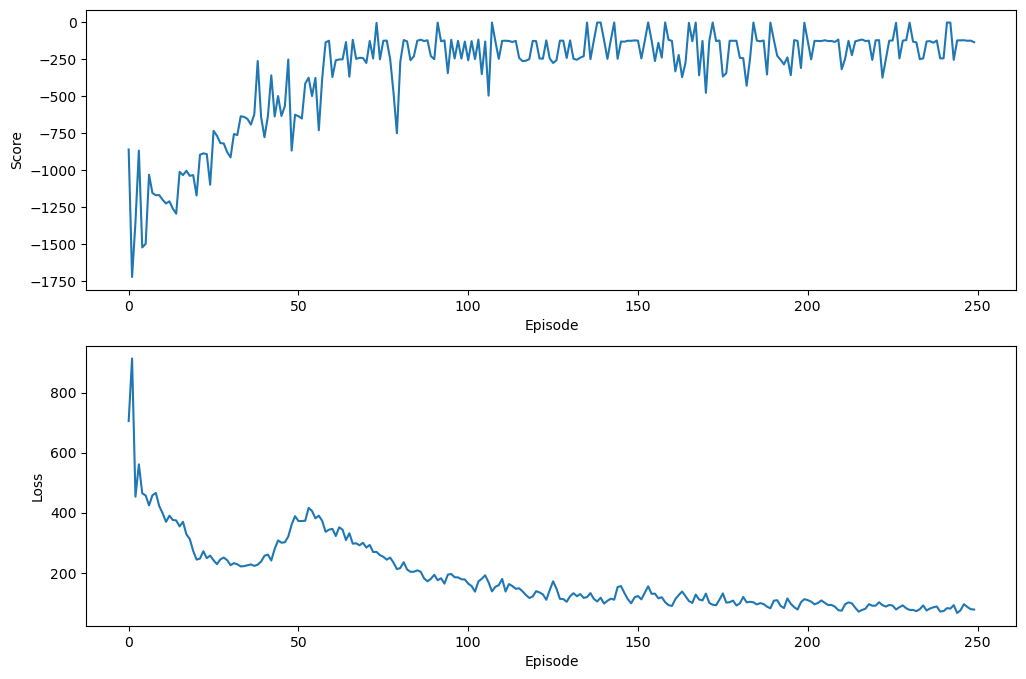

In [62]:
DQNV3_score = evaluate_model_perf(DQNV3_agent, simulations=10)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(score_list)
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Episode")

ax[1].plot(loss_list)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Episode")

plt.show()

In [66]:
scores_df.loc[len(scores_df)] = ["DQN", "Tuned Action Space", DQNV3_score, 75]

**Observations**:
- After increasing the number of actions from 9 to 17 and transforming the action space, the mean score deproved slightly from -153 to -156. However, the agent is now more stable with a lower standard deviation of just 91
- The agent also converges faster, and was able to balance the pendulum in a shorter amount of time

## **Double DQN** 
A Double DQN utilises Double Q-learning in order to reduce overoptimism due to estimation errors by decomposing the max operation in the target into action selection and action evaluation. This means that there are now two networks, the online network and a target network where we evaluate the $\epsilon$-greedy policy according to the online network but we use the target network to estimate its value ([Hasselt et. al , Deep Reinforcement Learning with Double Q-Learning, 2015](https://arxiv.org/pdf/1509.06461.pdf))

Every $\tau$ time steps, the target network will then be updated with the weights of the online network

In [68]:
class DDQNAgentV1:
    def __init__(self, use_gpu=False):
        self.state_dim     = 3
        self.action_dim    = 17
        self.lr            = 0.001
        self.gamma         = 0.95
        self.epsilon       = 1
        self.epsilon_decay = 0.95
        self.epsilon_min   = 0.001
        self.buffer_size   = 1_000_000
        self.batch_size    = 256
        self.memory        = ReplayBuffer(self.buffer_size)
        self.action_list = transform_action_values(self.action_dim)

        self.Q_online = QNetwork(self.state_dim, self.action_dim, self.lr)
        self.Q_target = QNetwork(self.state_dim, self.action_dim, self.lr)

        # Ensure target and online networks have same initial weights
        self.Q_target.load_state_dict(self.Q_online.state_dict())

        self.use_gpu = use_gpu  

        if self.use_gpu:
            self.Q_online.to(device)
            self.Q_target.to(device)

    def choose_action(self, state):
        """
        Choose an action using an epsilon-greedy policy
        """
        random_number = np.random.rand()
        

        # Exploitation
        if self.epsilon < random_number:
            with torch.no_grad():
                if self.use_gpu:
                    state = state.to(device)

                action = int(torch.argmax(self.Q_online(state)))
                
        # Exploration
        else:
            action = int(np.random.choice([n for n in range(self.action_dim)]))
        
        # Get actual action
        real_action = self.action_list[action]

        return action, real_action

    def calc_value(self, mini_batch):
        """
        Calculate the value of the current state using the Bellman equation
        """
        state, action, reward, new_state, done = mini_batch
        with torch.no_grad():
            if self.use_gpu:
                state = state.to(device)
                new_state = new_state.to(device)
                action = action.to(device)
                reward = reward.to(device)
                done = done.to(device)

            # Calculate expected longterm return of the current state under policy π
            q_target = self.Q_target(new_state).max(1)[0].unsqueeze(1)
            
            # Compute the target using the Bellman equation
            # Note: No need to compute the Q value of the next state if it is terminal
            value = reward + self.gamma * q_target * (1 - done)
        return value

    def train_agent(self):
        """
        Train the online network
        """
        # Sample from replay buffer
        mini_batch = self.memory.sample(self.batch_size)

        # Unpack
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = mini_batch

        if self.use_gpu:
            state_batch = state_batch.to(device)
            action_batch = action_batch.to(device)
            reward_batch = reward_batch.to(device)
            new_state_batch = new_state_batch.to(device)
            done_batch = done_batch.to(device)


        td_target = self.calc_value(mini_batch)

        # Train the Q network
        Q_a = self.Q_online(state_batch).gather(1, action_batch)
        q_loss = F.smooth_l1_loss(Q_a, td_target)
        self.Q_online.optimizer.zero_grad()
        q_loss.mean().backward()
        self.Q_online.optimizer.step()

        return float(q_loss)
    
    def update_target_network(self):
        """
        Update the target network
        """
        self.Q_target.load_state_dict(self.Q_online.state_dict())

In [69]:
DDQNV1_agent = DDQNAgentV1(use_gpu=True)

Env = InvertedPendulumEnv(render=False)

episodes = 250
score_list = []
loss_list = []

# Fill up the replay buffer with random actions
while DDQNV1_agent.memory.size() < 4 * DDQNV1_agent.batch_size:
    state, _info = Env.env.reset()
    done = False

    while not done:
        action, real_action = DDQNV1_agent.choose_action(torch.FloatTensor(state))
        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        if terminated or truncated:
            done = True

        DDQNV1_agent.memory.put((state, action, reward, new_state, terminated))
        state = new_state

# Train the agent
for episode in range(episodes):
    state, _info = Env.env.reset()
    score, eps_loss, done = 0.0, 0.0, False
    Q_action_count = 0

    while not done:
        action, real_action = DDQNV1_agent.choose_action(torch.FloatTensor(state))

        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        DDQNV1_agent.memory.put((state, action, reward, new_state, terminated))

        loss = DDQNV1_agent.train_agent()
        

        if terminated or truncated:
            done = True

        score += reward
        eps_loss += loss

        state = new_state
    
    # Decay epsilon every episode
    DDQNV1_agent.epsilon = max(DDQNV1_agent.epsilon_min, DDQNV1_agent.epsilon*DDQNV1_agent.epsilon_decay)

    # Update the target network every 5 episodes (1000 time steps)
    if (episode+1) % 5 == 0:
        DDQNV1_agent.update_target_network()

    print(f"EP:{episode+1}, Average Score:{score:.1f}, Average Loss:{eps_loss:.2f}, Epsilon:{DDQNV1_agent.epsilon:.5f}")

    score_list.append(score)
    loss_list.append(eps_loss)

EP:1, Average Score:-1458.1, Average Loss:342.89, Epsilon:0.95000
EP:2, Average Score:-1071.1, Average Loss:34.29, Epsilon:0.90250
EP:3, Average Score:-1021.9, Average Loss:12.68, Epsilon:0.85737
EP:4, Average Score:-922.5, Average Loss:6.43, Epsilon:0.81451
EP:5, Average Score:-917.4, Average Loss:3.72, Epsilon:0.77378
EP:6, Average Score:-1589.3, Average Loss:58.98, Epsilon:0.73509
EP:7, Average Score:-1624.7, Average Loss:4.44, Epsilon:0.69834
EP:8, Average Score:-1757.5, Average Loss:2.49, Epsilon:0.66342
EP:9, Average Score:-1456.4, Average Loss:1.74, Epsilon:0.63025
EP:10, Average Score:-1617.5, Average Loss:1.38, Epsilon:0.59874
EP:11, Average Score:-1043.0, Average Loss:54.74, Epsilon:0.56880
EP:12, Average Score:-1526.7, Average Loss:3.92, Epsilon:0.54036
EP:13, Average Score:-1660.6, Average Loss:2.56, Epsilon:0.51334
EP:14, Average Score:-1621.3, Average Loss:1.96, Epsilon:0.48767
EP:15, Average Score:-1288.0, Average Loss:1.65, Epsilon:0.46329
EP:16, Average Score:-1480.3, 

Result of 100 episodes: -125.78386020890338 ± 80.99884809895117


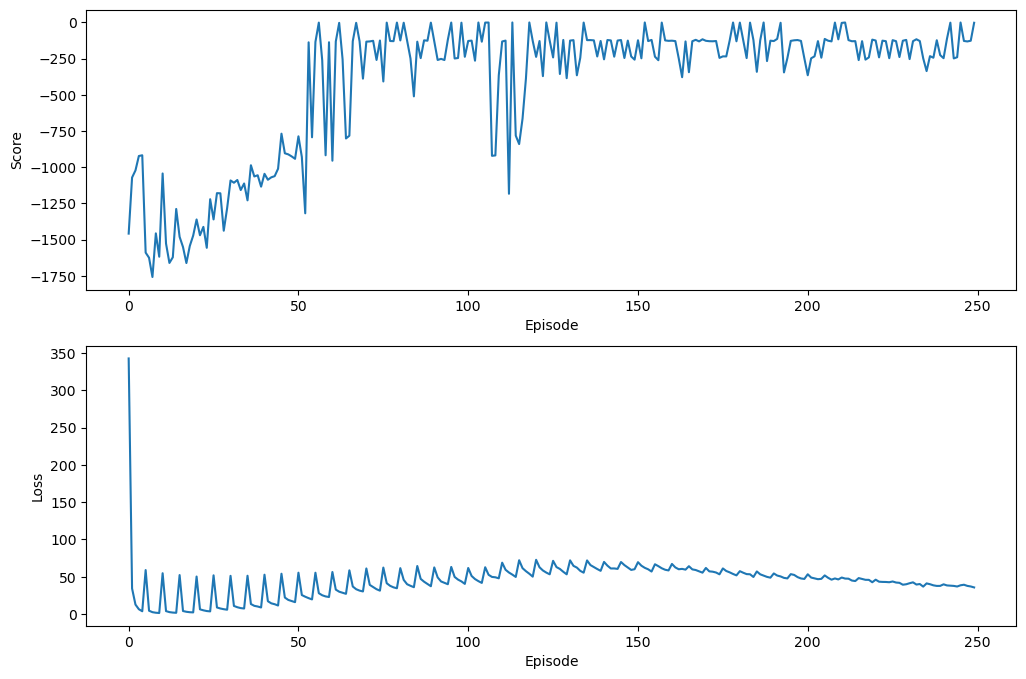

In [71]:
DDQNV1_score = evaluate_model_perf(DDQNV1_agent, simulations=10)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(score_list)
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Episode")

ax[1].plot(loss_list)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Episode")

plt.show()

In [72]:
scores_df.loc[len(scores_df)] = ["DDQN", "DDQN", DDQNV1_score, 55]

**Observations**:
- Using a double DQN network, the model was able to perform very well with a score of -125.78
- Even though the scores show that the pendulum is able to balance itself upright at the end, we can see the loss update is not very stable at the start. This can be remedied by updating the target network using soft update

### **Hard Update vs Soft Update** 
Previously, we used hard updating which periodically copies the online network weights over to the target network. However, the problem with this conventional update rule is that all the parameters are smoothly copied with the same speed from the online network, even when some of them are trying to update toward the wrong directions which increases the risk of generating the wrong reference signals ([Kobayashi et. al, t-Soft Update of Target Network for Deep Reinforcement Learning, 2020](https://arxiv.org/pdf/2008.10861.pdf))

Soft Updating works by tackling the instability of DQN by slowly incorporating updates from the online network instead of just copying the weights over periodically. This is done using Polyak Averaging, where every timestep, the target network smoothly transition to the online network using a pre-defined softness factor $\tau$ preventing abrupt changes and stabilizing learning. The soft update of the weights can be described as:

$$
\phi_{i} = (1-\tau)\phi_{i} + \tau\theta_{i}
$$

where
$\phi_{i}$ is the parameters of the target network
$\theta_{i}$ is the parameters of the online network
$\tau$ is the softness factor and $\tau \in (0, 1]$

*Figure: Soft Update Rule: (a) when $\theta$ is close to $\phi$, the update rate of the t-soft update accelerates the update of $\phi$ towards $\theta$; (b) when $\theta$ is far from $\phi$, the update of $\phi$ is suppressed since this rule suspects that $\theta$ is wrong*

In [8]:
class DDQNAgentV2:
    def __init__(self, use_gpu=False):
        self.state_dim     = 3
        self.action_dim    = 17
        self.lr            = 0.001
        self.gamma         = 0.95
        self.tau           = 0.01
        self.epsilon       = 1
        self.epsilon_decay = 0.95
        self.epsilon_min   = 0.001
        self.buffer_size   = 1_000_000
        self.batch_size    = 256
        self.memory        = ReplayBuffer(self.buffer_size)
        self.action_list = transform_action_values(self.action_dim)

        self.Q_online = QNetwork(self.state_dim, self.action_dim, self.lr)
        self.Q_target = QNetwork(self.state_dim, self.action_dim, self.lr)

        # Ensure target and online networks have same initial weights
        self.Q_target.load_state_dict(self.Q_online.state_dict())

        self.use_gpu = use_gpu  

        if self.use_gpu:
            self.Q_online.to(device)
            self.Q_target.to(device)

    def choose_action(self, state):
        """
        Choose an action using an epsilon-greedy policy
        """
        random_number = np.random.rand()

        # Exploitation
        if self.epsilon < random_number:
            with torch.no_grad():
                if self.use_gpu:
                    state = state.to(device)

                action = int(torch.argmax(self.Q_online(state)))
                
        # Exploration
        else:
            action = int(np.random.choice([n for n in range(self.action_dim)]))
        
        # Get actual action
        real_action = self.action_list[action]

        return action, real_action

    def calc_value(self, mini_batch):
        """
        Calculate the value of the current state using the Bellman equation
        """
        state, action, reward, new_state, done = mini_batch
        with torch.no_grad():
            if self.use_gpu:
                state = state.to(device)
                new_state = new_state.to(device)
                action = action.to(device)
                reward = reward.to(device)
                done = done.to(device)

            # Calculate expected longterm return of the current state under policy π
            q_target = self.Q_target(new_state).max(1)[0].unsqueeze(1)
            
            # Compute the target using the Bellman equation
            # Note: No need to compute the Q value of the next state if it is terminal
            value = reward + self.gamma * q_target * (1 - done)
        return value

    def train_agent(self):
        """
        Train the online network
        """
        # Sample from replay buffer
        mini_batch = self.memory.sample(self.batch_size)

        # Unpack
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = mini_batch

        if self.use_gpu:
            state_batch = state_batch.to(device)
            action_batch = action_batch.to(device)
            reward_batch = reward_batch.to(device)
            new_state_batch = new_state_batch.to(device)
            done_batch = done_batch.to(device)


        td_target = self.calc_value(mini_batch)

        # Train the Q network
        Q_a = self.Q_online(state_batch).gather(1, action_batch)
        q_loss = F.smooth_l1_loss(Q_a, td_target)
        self.Q_online.optimizer.zero_grad()
        q_loss.mean().backward()
        self.Q_online.optimizer.step()

        # Q soft-update
        for param_target, param in zip(self.Q_target.parameters(), self.Q_online.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

        return float(q_loss)


In [75]:
DDQNV2_agent = DDQNAgentV2(use_gpu=True)

Env = InvertedPendulumEnv(render=False)

episodes = 250

score_list = []
loss_list = []

# Fill up the replay buffer with random actions
while DDQNV2_agent.memory.size() < 4 * DDQNV2_agent.batch_size:
    state, _info = Env.env.reset()
    done = False

    while not done:
        action, real_action = DDQNV2_agent.choose_action(torch.FloatTensor(state))
        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        if terminated or truncated:
            done = True

        DDQNV2_agent.memory.put((state, action, reward, new_state, terminated))
        state = new_state

# Train the agent
for episode in range(episodes):
    state, _info = Env.env.reset()
    score, eps_loss, done = 0.0, 0.0, False
    Q_action_count = 0

    while not done:
        action, real_action = DDQNV2_agent.choose_action(torch.FloatTensor(state))

        new_state, reward, terminated, truncated, _ = Env.env.step([real_action])

        DDQNV2_agent.memory.put((state, action, reward, new_state, terminated))

        loss = DDQNV2_agent.train_agent()
        

        if terminated or truncated:
            done = True

        score += reward
        eps_loss += loss

        state = new_state
    
    # Decay epsilon every episode
    DDQNV2_agent.epsilon = max(DDQNV2_agent.epsilon_min, DDQNV2_agent.epsilon*DDQNV2_agent.epsilon_decay)

    print(f"EP:{episode+1}, Average Score:{score:.1f}, Average Loss:{eps_loss:.2f}, Epsilon:{DDQNV2_agent.epsilon:.5f}")

    score_list.append(score)
    loss_list.append(eps_loss)

EP:1, Average Score:-826.8, Average Loss:563.39, Epsilon:0.95000
EP:2, Average Score:-1037.8, Average Loss:51.30, Epsilon:0.90250
EP:3, Average Score:-1233.9, Average Loss:26.09, Epsilon:0.85737
EP:4, Average Score:-1259.2, Average Loss:21.76, Epsilon:0.81451
EP:5, Average Score:-1481.4, Average Loss:25.60, Epsilon:0.77378
EP:6, Average Score:-1626.1, Average Loss:29.36, Epsilon:0.73509
EP:7, Average Score:-973.9, Average Loss:36.57, Epsilon:0.69834
EP:8, Average Score:-1036.9, Average Loss:61.77, Epsilon:0.66342
EP:9, Average Score:-1091.9, Average Loss:71.65, Epsilon:0.63025
EP:10, Average Score:-1188.9, Average Loss:80.02, Epsilon:0.59874
EP:11, Average Score:-1076.0, Average Loss:82.87, Epsilon:0.56880
EP:12, Average Score:-691.9, Average Loss:83.37, Epsilon:0.54036
EP:13, Average Score:-1151.7, Average Loss:95.48, Epsilon:0.51334
EP:14, Average Score:-996.7, Average Loss:107.87, Epsilon:0.48767
EP:15, Average Score:-1192.7, Average Loss:110.29, Epsilon:0.46329
EP:16, Average Score

Result of 100 episodes: -143.99074814856843 ± 78.1283881695136


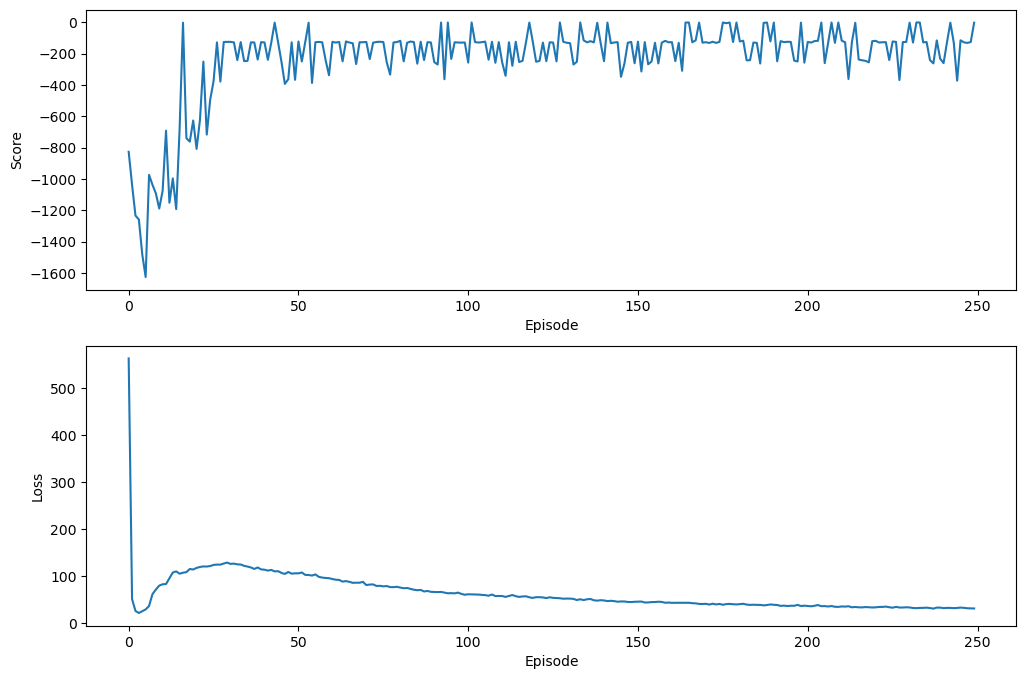

In [83]:
DDQNV2_score = evaluate_model_perf(DDQNV2_agent, simulations=10)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(score_list)
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Episode")

ax[1].plot(loss_list)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Episode")

plt.show()

In [87]:
scores_df.loc[len(scores_df)] = ["DDQN", "Soft Update", DDQNV2_score, 30]

**Observations**:
- Although it seems that Soft Update performed slightly worse compared to Hard Update, it is likely because our low score for Hard Update DDQN was due to luck
- However, the soft update DDQN has a slightly better standard deviation and converges much faster at only 30 episodes

### **Prioritized Double DQN** 

Experience Replay Buffers use uniform sampling over all elements of the buffer to collect mini batches used to train the Q Network. Over the course of training however, there can be some samples that the Q Network finds harder to learn than others which would be indicated by a higher loss.

The Prioritized Experience Replay Buffer makes use of the magnitude of the Temporal Difference (TD) Error, $\delta$, as a reasonable proxy to how much the RL Agent can learn from a transition in its current state. ([Schaul et. al, Prioritized Experience Replay, 2016](https://arxiv.org/pdf/1511.05952.pdf)). 

The TD Error, $\delta$, is then used to calculate the priority of each sample which is then used for weighted sampling. This way, samples that the Q Network does not perform well on have a higher probability of being trained more often. 

In [94]:
from torchrl.data import PrioritizedReplayBuffer
from torchrl.data.replay_buffers import ListStorage

In [95]:
class DDQNAgentV3:
    def __init__(self):
        self.state_dim     = 3
        self.action_dim    = 17
        self.lr            = 0.001
        self.gamma         = 0.95
        self.tau           = 0.01
        self.epsilon       = 1
        self.epsilon_decay = 0.95
        self.epsilon_min   = 0.001
        self.buffer_size   = 1_000_000
        self.alpha         = 0.9
        self.beta          = 0.5
        self.batch_size    = 256
        self.memory        = PrioritizedReplayBuffer(alpha=self.alpha, beta=self.beta, storage=ListStorage(max_size=self.buffer_size))
        self.action_list = transform_action_values(self.action_dim)

        self.Q_online        = QNetwork(self.state_dim, self.action_dim, self.lr)
        self.Q_target = QNetwork(self.state_dim, self.action_dim, self.lr)

        # Ensure target and online networks have same initial weights
        self.Q_target.load_state_dict(self.Q_online.state_dict())

    def choose_action(self, state):
        random_number = np.random.rand()
        
        # Exploitation
        if self.epsilon < random_number:
            with torch.no_grad():
                action = int(torch.argmax(self.Q_online(state)).numpy())
                
        # Exploration
        else:
            action = int(np.random.choice([n for n in range(self.action_dim)]))
        
        # Get actual action
        real_action = self.action_list[action]

        return action, real_action

    def calc_value(self, mini_batch):
        s, a, r, s_prime, done = mini_batch
        with torch.no_grad():
            q_target = self.Q_target(s_prime).max(1)[0]
            # Compute the target using the Bellman equation
            # Note: No need to compute the Q value of the next state if it is terminal
            value = r + self.gamma * q_target * (1 - done)
        return value.unsqueeze(1)

    def train_agent(self):
        mini_batch, info = self.memory.sample(self.batch_size, return_info=True)
        indices = info['index']
        weights = info['_weight']


        s_batch, a_batch, r_batch, s_prime_batch, done_batch = mini_batch
        a_batch = a_batch.type(torch.int64).unsqueeze(1)

        td_target = self.calc_value(mini_batch)

        # Train the Q network
        Q_a = self.Q_online(s_batch).gather(1, a_batch)
        q_loss = F.smooth_l1_loss(Q_a, td_target)
        self.Q_online.optimizer.zero_grad()
        q_loss.mean().backward()
        self.Q_online.optimizer.step()

        # Q soft-update
        for param_target, param in zip(self.Q_target.parameters(), self.Q_online.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

        # Update Priorities
        td_error = (Q_a - td_target).abs().detach().numpy()

        self.memory.update_priority(indices, td_error)

        return float(q_loss)

In [96]:
DDQNV3_agent = DDQNAgentV3()

env = gym.make('Pendulum-v1')

episodes = 250
score_list = []
loss_list = []

for episode in range(episodes):
    state, _info = env.reset()

    score, eps_loss, done = 0.0, 0.0, False

    while not done:
        action, real_action = DDQNV3_agent.choose_action(torch.FloatTensor(state))

        new_state, reward, terminated, truncated, _ = env.step([real_action])

        terminated = int(terminated)
        DDQNV3_agent.memory.extend([(state, action, reward, new_state, terminated)])

        loss = DDQNV3_agent.train_agent()

        if terminated or truncated:
            done = True

        score += reward
        eps_loss += loss

        state = new_state
    
    # Decay epsilon every episode
    DDQNV3_agent.epsilon = max(DDQNV3_agent.epsilon_min, DDQNV3_agent.epsilon*DDQNV3_agent.epsilon_decay)
    print(f"EP:{episode+1}, Average Score:{score:.1f}, Average Loss:{eps_loss:.2f}, Epsilon:{DDQNV3_agent.epsilon:.5f}")
    score_list.append(score)
    loss_list.append(eps_loss)



EP:1, Average Score:-954.2, Average Loss:681.91, Epsilon:0.95000
EP:2, Average Score:-1073.0, Average Loss:164.85, Epsilon:0.90250
EP:3, Average Score:-1724.9, Average Loss:121.40, Epsilon:0.85737
EP:4, Average Score:-1113.1, Average Loss:111.27, Epsilon:0.81451
EP:5, Average Score:-1779.1, Average Loss:123.33, Epsilon:0.77378
EP:6, Average Score:-1207.3, Average Loss:138.66, Epsilon:0.73509
EP:7, Average Score:-1369.5, Average Loss:177.96, Epsilon:0.69834
EP:8, Average Score:-1401.2, Average Loss:191.28, Epsilon:0.66342
EP:9, Average Score:-900.9, Average Loss:257.20, Epsilon:0.63025
EP:10, Average Score:-1172.7, Average Loss:365.46, Epsilon:0.59874
EP:11, Average Score:-1205.3, Average Loss:399.14, Epsilon:0.56880
EP:12, Average Score:-1012.5, Average Loss:343.17, Epsilon:0.54036
EP:13, Average Score:-898.7, Average Loss:290.62, Epsilon:0.51334
EP:14, Average Score:-840.2, Average Loss:253.17, Epsilon:0.48767
EP:15, Average Score:-934.4, Average Loss:253.55, Epsilon:0.46329
EP:16, Av

Result of 100 episodes: -148.47179351700527 ± 93.65330057623711


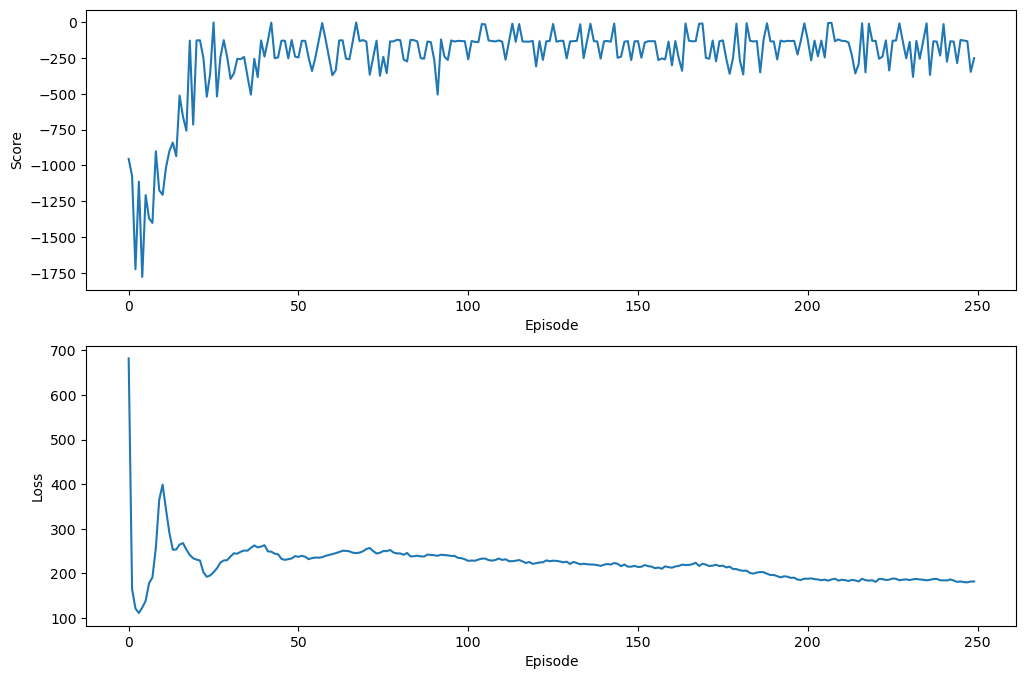

In [100]:
DDQNV3_score = evaluate_model_perf(DDQNV3_agent, simulations=10)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(score_list)
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Episode")

ax[1].plot(loss_list)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Episode")

plt.show()

In [102]:
scores_df.loc[len(scores_df)] = ["DDQN", "Prioritized Replay Buffer", DDQNV3_score, 30]

**Observations**:
- It seems that Prioritized Replay Buffer did not perform as well for DDQN with a slightly worse score and a much larger standard deviation. This is likely because the Pendulum Environment can be solved in very few episodes (30 in our case) that the Prioritized Replay Buffer did not have enough time to give meaninful priority for each sample making it more of a hindrance rather than helping the model

### Conclusion

In [104]:
display(scores_df)

,Model,Description,Scores,Solved In
0,DQN,DQN,-1399.29 ± 246.07,Never
1,DQN,Tuned Gamma,-153.27 ± 100.51,90
2,DQN,Tuned Action Space,-156.09 ± 91.43,75
3,DDQN,DDQN,-125.78 ± 81.00,55
4,DDQN,Soft Update,-143.99 ± 78.13,30
5,DDQN,Prioritized Replay Buffer,-148.47 ± 93.65,30


It seems that most of our models were able to solve the environment in less than 100 episodes. In fact our Double DQN models performed well enough to be in the leaderboard with DDQN with Soft Update and DDQN with Prioritized Replay Buffer being in 8th place and Vanilla DDQN being in 4th place in terms of their mean scores although the standard deviations are considered higher compared to the leaderboard

<ins>[OpenAI Leaderboard ](https://github.com/openai/gym/wiki/Leaderboard) for reference</ins>

| Position | User | Best 100-Episode Performance |
| -------- | ---- | ---------------------------- |
| 1 | KanishkNavale | -106.9528 |
| 2 | msinto93 | -123.11 ± 6.86 |
| 3 | msinto93 | -123.79 ± 6.90 |
| 4 | heerad | -134.48 ± 9.07 |
| 5 | BS Haney | 	-135 |
| 6 | ThyrixYang | -136.16 ± 11.97 |
| 7 | MaelFrancesc | -146.4 (mean 900 ep) |
| 8 | lirnli | 	-152.24 ± 10.87 |

We will save the model's of our best performing agent's to disk so that we can use them later. Although our DDQN with Hard Updating had the best performance, it was likely due to luck during evaluation and DDQN with Soft Updating is likely better as indicated by the lower standard deviation and faster speed in which it is able to balance the pendulum

In [93]:
# Save the model of Q_online and Q_target of DDQN V2
torch.save(DDQNV2_agent.Q_online.state_dict(), "DDQN_V2_Q_online.pth")
torch.save(DDQNV2_agent.Q_target.state_dict(), "DDQN_V2_Q_target.pth")

In [9]:
eval_agent = DDQNAgentV2(use_gpu=True)

In [10]:
# Load the model of Q_online and Q_target of DDQN V2
eval_agent.Q_online.load_state_dict(torch.load("DDQN_V2_Q_online.pth"))
eval_agent.Q_target.load_state_dict(torch.load("DDQN_V2_Q_target.pth"))

<All keys matched successfully>

In [15]:
env = InvertedPendulumEnv(render=True)
env.initialize()
evaluate_model_perf(eval_agent, env, simulations=1, episodes=3, printResults=False)
env.close()

Window closed by user.


In [ ]:
eval_agent = DDQNAgentV2(use_gpu=True)

# Load the model of Q_online and Q_target of DDQN V2
eval_agent.Q_online.load_state_dict(torch.load("DDQN_V2_Q_online.pth"))
eval_agent.Q_target.load_state_dict(torch.load("DDQN_V2_Q_target.pth"))

## Summary
In summary, we were able to solve the environment and balance the Pendulum with both a vanilla DQN agent and a Double DQN agent where our best agent (Double DQN with Soft Updating) solved the environment in 30 episodes. From our hyperparameter tuning, it shows that the discount factor is very sensitive but one of the most important parameters when tuning DQN where gamma of 0.99 was unable to converge but gamma of 0.95 was able to when using the same architecture.<br>
<br>
**Some potential issues with the agents:**
- Although they were able to solve the environment, the scores still varied a lot (standard deviation of ±80) compared to those on the leaderboard (standard deviation of ±10). This is likely due to the nature of DQN Agents in general being more unstable compared to other Actor Critic Agents